In [33]:
from astropy.io import fits
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import subprocess
from sklearn.cluster import DBSCAN
from analyzeImage import analyzeImage
import keras
from keras.models import load_model
from __future__ import print_function
%matplotlib inline

In [36]:
gpu_code_path = "../code/gpu/"
real_image_name = "chip_7"
real_image_path = "../../HITS/trimmed_chip_03/Blind15A_02/night_1/" #gpu_code_path+"images/"+real_image_name
psi_image_path = gpu_code_path+"output-images/psi"
phi_image_path = gpu_code_path+"output-images/phi"

In [37]:
def execute(cmd):
    popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    for stdout_line in iter(popen.stdout.readline, ""):
        yield stdout_line 
    popen.stdout.close()
    return_code = popen.wait()
    if return_code:
        raise subprocess.CalledProcessError(return_code, cmd)

In [38]:
paramsFile = open('../code/gpu/debug/parameters.config', 'w')
paramsFile.write(
"""Debug ................ : 1
Image Count .......... : 5
Generate Images ...... : 0
Image Width .......... : 500
Image Height ......... : 500
PSF Sigma ............ : 1.0
Object Brightness .... : 360.0
Object Initial x ..... : 320.0
Object Initial y ..... : 180.0
Velocity x ........... : -1.3
Velocity y ........... : -0.2
Background Level ..... : 1024.0
Background Sigma ..... : 32.0
Mask Threshold ....... : 40.0
Mask Penalty ......... : 15.0
Angles to Search ..... : 80
Velocities to Search . : 20
Minimum Velocity ..... : 300
Maximum Velocity ..... : 450
Write to file ........ : 1
Source Images Path ... : ../../{source}/
Psi Images Path ...... : ../../{psi}/
Phi Images Path....... : ../../{phi}/
""".format( source=real_image_path, psi=psi_image_path, phi=phi_image_path ))
paramsFile.close()

In [5]:
#popen = subprocess.Popen( "./clearImages.sh", stdout=subprocess.PIPE, 
#                         stderr=subprocess.PIPE)
#popen.wait()
#output = popen.stderr.read()
#output += popen.stdout.read()
#print( output)

In [40]:
#for path in execute("./search.sh"):
#    print(path, end="")

In [39]:
raw_results = np.genfromtxt('../data/results/HITS1.txt', names=True)

In [41]:
image_mjd = []

for filename in sorted(os.listdir(real_image_path)):
    hdulist = fits.open(os.path.join(real_image_path, filename))
    image_mjd.append(hdulist[0].header['MJD'])

image_mjd = np.array(image_mjd)
image_times = image_mjd - image_mjd[0]
#image_times*=24.

Load Psi Images

In [42]:
hdulist = fits.open(os.path.join(psi_image_path, os.listdir(psi_image_path)[0]))
num_images = len(os.listdir(psi_image_path))
image_shape = np.shape(hdulist[0].data)
im_psi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(psi_image_path)))):

    #print (str('Loaded ' + filename))

    image_file = os.path.join(psi_image_path, filename)
    hdulist = fits.open(image_file)
    im_psi_array[idx] = hdulist[0].data#*mask


Load Phi Images (for potentially making psi/phi stamps)

In [43]:
hdulist = fits.open(os.path.join(phi_image_path, os.listdir(phi_image_path)[0]))
num_images = len(os.listdir(phi_image_path))
image_shape = np.shape(hdulist[0].data)
im_phi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(phi_image_path)))):

   # print (str('Loaded ' + filename))

    image_file = os.path.join(phi_image_path, filename)
    hdulist = fits.open(image_file)
    im_phi_array[idx] = hdulist[0].data#*mask


In [44]:
hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
num_images = len(os.listdir(real_image_path))
image_shape = np.shape(hdulist[1].data)
im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

   # print( str('Loaded ' + filename))

    image_file = os.path.join(real_image_path, filename)
    hdulist = fits.open(image_file)
    im_array[idx] = hdulist[1].data#*mask


In [45]:
ai = analyzeImage()

In [46]:
model = load_model('../data/kbmod_model.h5')

In [47]:
results = raw_results[0:8000]
results

array([(1565.0, 2823.0, 0.0, 0.0, 0.722, -0.277, 15.43, 416.453),
       (1572.0, 2822.0, 0.0, 0.0, -0.124, -0.38, 15.41, 445.565),
       (1565.0, 2824.0, 0.0, 0.0, 0.885, -0.511, 15.38, 429.147), ...,
       (1529.0, 2898.0, 0.0, 0.0, -2.885, 0.151, 7.567, 202.331),
       (1534.0, 2898.0, 0.0, 0.0, -3.382, 0.178, 7.567, 217.438),
       (1546.0, 2785.0, 0.0, 0.0, 2.795, 3.847, 7.566, 195.27)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [48]:
filtered_results = ai.filter_results(im_array, results, image_times, model, chunk_size=2000)

Finished chunk 1 of 4
Finished chunk 2 of 4
Finished chunk 3 of 4
Finished chunk 4 of 4


In [49]:
print( len(filtered_results) )
filtered_results

199


array([(1582.0, 2814.0, 0.0, 0.0, -1.855, 1.071, 9.83, 361.498),
       (1581.0, 2813.0, 0.0, 0.0, -1.834, 1.332, 9.696, 340.848),
       (1583.0, 2815.0, 0.0, 0.0, -2.02, 1.029, 9.612, 348.979),
       (1583.0, 2814.0, 0.0, 0.0, -1.855, 1.071, 9.542, 368.942),
       (1581.0, 2812.0, 0.0, 0.0, -1.761, 1.427, 9.509, 345.425),
       (1582.0, 2813.0, 0.0, 0.0, -1.834, 1.332, 9.475, 347.583),
       (1584.0, 2814.0, 0.0, 0.0, -2.02, 1.029, 9.346, 358.982),
       (1584.0, 2815.0, 0.0, 0.0, -2.071, 0.922, 9.346, 358.982),
       (1581.0, 2811.0, 0.0, 0.0, -1.858, 1.505, 9.327, 330.251),
       (1650.0, 2852.0, 0.0, 0.0, -0.365, 0.163, 9.322, 254.184),
       (1583.0, 2813.0, 0.0, 0.0, -2.005, 1.302, 9.265, 339.014),
       (1584.0, 2813.0, 0.0, 0.0, -2.071, 1.196, 9.169, 354.484),
       (1582.0, 2812.0, 0.0, 0.0, -1.834, 1.332, 9.167, 340.226),
       (1650.0, 2854.0, 0.0, 0.0, -0.297, -0.268, 9.159, 244.69),
       (1650.0, 2851.0, 0.0, 0.0, -0.268, 0.297, 9.153, 246.021),
       (1584.

In [50]:
results_to_cluster = filtered_results
arg = dict(eps=0.01, min_samples=1, n_jobs=-1)
clustered_results = ai.clusterResults(results_to_cluster, dbscan_args=arg)#, im_array, image_times)
clustered_results =  results_to_cluster[np.array(clustered_results[1], dtype=np.int)]
#best_targets = range(stamp_count)
#best_targets

In [51]:
print( len(clustered_results) )
clustered_results

11


array([(1582.0, 2814.0, 0.0, 0.0, -1.855, 1.071, 9.83, 361.498),
       (1650.0, 2852.0, 0.0, 0.0, -0.365, 0.163, 9.322, 254.184),
       (1578.0, 2846.0, 0.0, 0.0, -0.877, -3.271, 8.885, 358.888),
       (1654.0, 2856.0, 0.0, 0.0, -0.547, -0.547, 7.999, 205.911),
       (1537.0, 2902.0, 0.0, 0.0, -3.739, -0.393, 7.957, 247.652),
       (1532.0, 2903.0, 0.0, 0.0, -3.222, -0.51, 7.781, 227.639),
       (1534.0, 2905.0, 0.0, 0.0, -3.434, -0.73, 7.744, 226.18),
       (1508.0, 2899.0, 0.0, 0.0, -0.513, 0.109, 7.708, 193.794),
       (1535.0, 2900.0, 0.0, 0.0, -3.506, -0.183, 7.642, 232.031),
       (1530.0, 2901.0, 0.0, 0.0, -2.997, -0.315, 7.642, 218.78),
       (1502.0, 2905.0, 0.0, 0.0, 0.314, -0.707, 7.63, 192.56)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [52]:
#im_psi_array

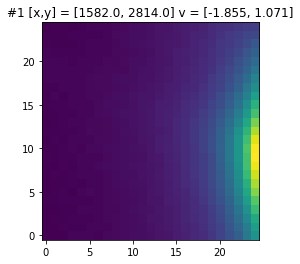

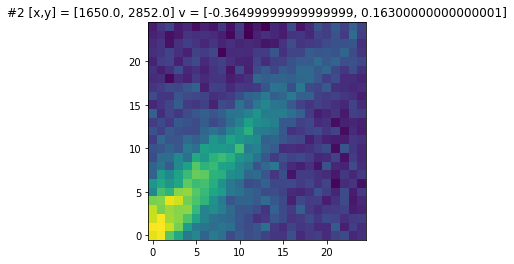

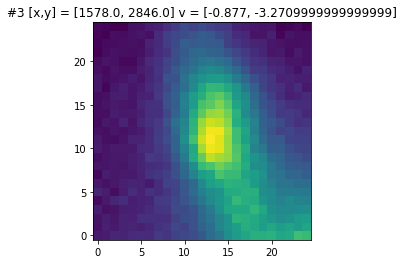

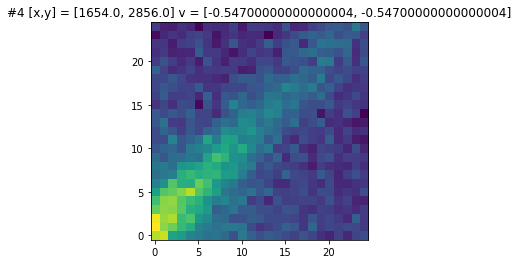

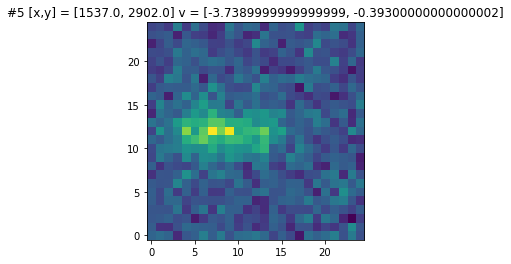

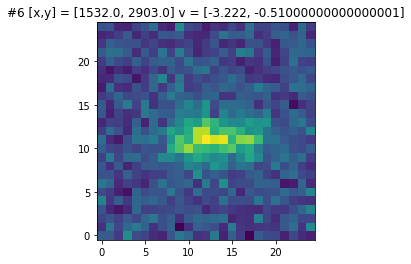

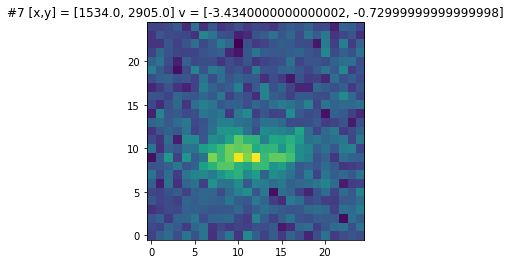

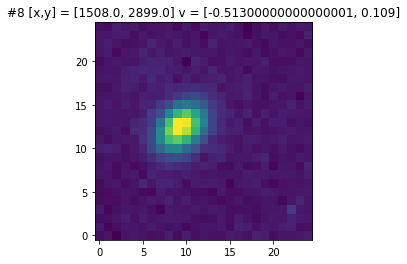

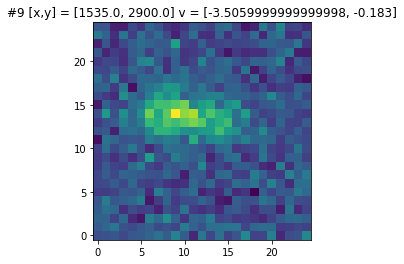

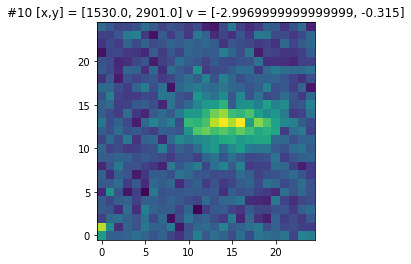

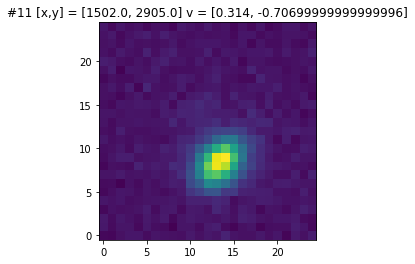

In [53]:
f_results = clustered_results#filtered_results
for imNum in range(min(len(f_results),50)):
    current = imNum#best_targets[imNum]    
    plt.imshow(ai.createPostageStamp(im_array,
                                         list(f_results[['t0_x', 't0_y']][current]),
                                         np.array(list(f_results[['v_x', 'v_y']][current])),
                                         image_times, 
                                         [25., 25.])[0],
                    origin='lower',
               #cmap=plt.cm.Greys_r,
               interpolation='None')
    plt.title(str('#' + str(imNum+1) + ' [x,y] = ' + str(list(f_results[['t0_x', 't0_y']][current])))
                  + ' v = ' + str(list(f_results[['v_x', 'v_y']][current])))
 #   plt.savefig("stamps/stamp"+str(imNum+1)+".png")
    plt.show()


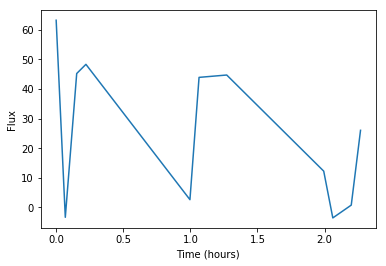

In [69]:
ai.plotLightCurves(im_array, f_results[8], image_times)

In [70]:
image_times

array([ 0.       ,  0.0680697,  0.153044 ,  0.2217088,  0.996763 ,
        1.0646263,  1.2708684,  1.9935337,  2.0612634,  2.1987387,
        2.2678587])